***
# Timeseries anomaly detection.

Below script demonstrates use of keras library to show a reconstruction convolutional autoencoder model for detecting anomalies in timeseries data.


Based on the website:

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

File used from keggle website:

https://www.kaggle.com/datasets/boltzmannbrain/nab


In model is used Numenta Anomaly Benchmark(NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.
According to keggle website, The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. 
Some of available datasets are: AWS server metrics, online advertisement clicking rates, temperature sensor, real time traffic data and more.

In case of presented below model,artificial datasets are used:
- art_daily_small_noise.csv -  for training
- art_daily_jumpsup.csv  - for testing

More information and datasets is available on the NAB github page https://github.com/numenta/NAB 

****

### Import modules and load data sets.
***

In [1]:
# Numerical arrays.
import numpy as np

# Spread-sheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting.
import matplotlib.pyplot as plt

In [2]:
# Get urls for datasets.
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Dataset with anomaly.
with_anomaly_url = "artificialWithAnomaly/art_daily_jumpsup.csv"

# Dataset without anomaly.
no_anomaly_url = "artificialNoAnomaly/art_daily_small_noise.csv"

In [3]:
# Read csv dataset with anomaly from url by Pandas.
df_anomaly_url = master_url_root + with_anomaly_url
df_anomaly = pd.read_csv(df_anomaly_url, parse_dates=True, index_col="timestamp")

In [4]:
# Check dataset.
df_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [5]:
# Read csv dataset without anomaly from url by Pandas.
df_no_anomaly_url = master_url_root + no_anomaly_url
df_no_anomaly = pd.read_csv(df_no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Check dataset.
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


### Visualize the data.
***

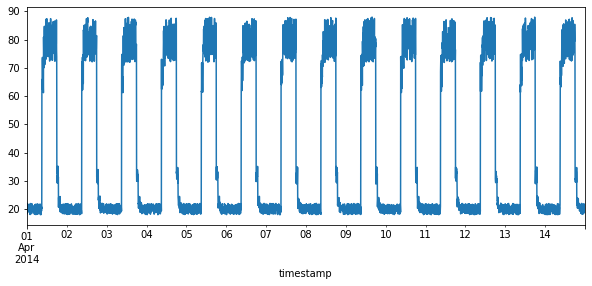

In [7]:
# Visualize the data - timeseries without anomalies.
fig, ax = plt.subplots(figsize=(10,4))
df_no_anomaly.plot(legend=False, ax=ax)
plt.show()

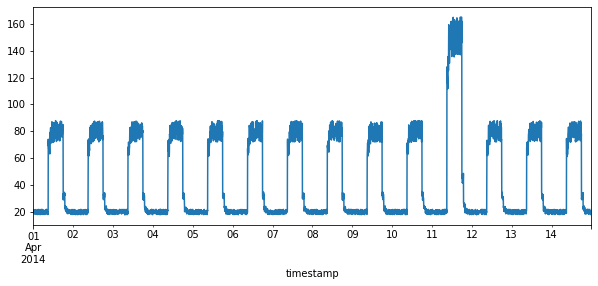

In [8]:
# Visualize the data - timeseries with anomalies.
fig, ax = plt.subplots(figsize=(10,4))
df_anomaly.plot(legend=False, ax=ax)
plt.show()

### Prepare training data.
***

Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

    24 * 60 / 5 = 288 timesteps per day
    288 * 14 = 4032 data points in total


In [10]:
# Normalize and save the mean and std.
training_mean = df_anomaly.mean()
training_std = df_anomaly.std()
df_training_value = (df_anomaly - training_mean) / training_std
print("Number of training samples: ", len(df_training_value))

Number of training samples:  4032


### Create sequences.
***

Functions used:
 - create_sequences() - create function to generate training sequences,
 - np.stack() - function that joins a sequence of arrays along a new axis.

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    #print(output[0])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)


### Build a model.
***

Model used here: a convolutional reconstruction autoencoder model.
According to the 

https://blog.keras.io/building-autoencoders-in-keras.html

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.
To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function).

Below we use sequential function to create a model. A Sequential model is appropriate for plain stock of layers when each layer has exactly one input tensor and one output tensor. Below model has seven layers passed as a list of layers. 

https://keras.io/

https://www.tensorflow.org/

Methods used on layers:
 - ***Input*** - is used to instantiate a Keras tensor. 
           Arguments in function ( bolded are used in the function below:
                --> ***shape***: A shape tuple (integers), not including the batch size. For instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.
                --> batch_size: optional static batch size (integer).
                --> name: An optional name string for the layer. Should be unique in a model (do not reuse the same name twice). It will be autogenerated if it isn't provided.
                --> dtype: The data type expected by the input, as a string (float32, float64, int32...)
                --> sparse: A boolean specifying whether the placeholder to be created is sparse. Only one of 'ragged' and 'sparse' can be True. Note that, if sparse is False, sparse tensors can still be passed into the input - they will be densified with a default value of 0.
                --> tensor: Optional existing tensor to wrap into the Input layer. If set, the layer will use the tf.TypeSpec of this tensor rather than creating a new placeholder tensor.
                --> ragged: A boolean specifying whether the placeholder to be created is ragged. Only one of 'ragged' and 'sparse' can be True. In this case, values of 'None' in the 'shape' argument represent ragged dimensions. For more information about RaggedTensors, see this guide.
                --> type_spec: A tf.TypeSpec object to create the input placeholder from. When provided, all other args except name must be None.
      Function returns: A tensor.
      
 - ***Conv1D*** - It is 1D convolution layer. This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
             Arguments in function:
                --> ***filters***: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
                --> ***kernel_size***: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
                --> ***strides***: An integer or tuple/list of a single integer, specifying the stride length of the convolution. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
                --> ***padding***: One of "valid", "same" or "causal" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section 2.1.
                --> data_format: A string, one of channels_last (default) or channels_first.
                --> dilation_rate: an integer or tuple/list of a single integer, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.
                --> groups: A positive integer specifying the number of groups in which the input is split along the channel axis. Each group is convolved separately with filters / groups filters. The output is the concatenation of all the groups results along the channel axis. Input channels and filters must both be divisible by groups.
                --> ***activation***: Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
                --> use_bias: Boolean, whether the layer uses a bias vector.
                --> kernel_initializer: Initializer for the kernel weights matrix (see keras.initializers). Defaults to 'glorot_uniform'.
                --> bias_initializer: Initializer for the bias vector (see keras.initializers). Defaults to 'zeros'.
                --> kernel_regularizer: Regularizer function applied to the kernel weights matrix (see keras.regularizers).
                --> bias_regularizer: Regularizer function applied to the bias vector (see keras.regularizers).
                --> activity_regularizer: Regularizer function applied to the output of the layer (its "activation") (see keras.regularizers).
                --> kernel_constraint: Constraint function applied to the kernel matrix (see keras.constraints).
                --> bias_constraint: Constraint function applied to the bias vector (see keras.constraints).
        Function returns a tensor of rank 3 representing activation(conv1d(inputs, kernel) + bias).

 - ***Dropout*** - The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
             Arguments in function:
                 --> ***rate***: Float between 0 and 1. Fraction of the input units to drop.
                 --> noise_shape: 1D integer tensor representing the shape of the binary dropout mask that will be multiplied with the input. For instance, if your inputs have shape (batch_size, timesteps, features) and you want the dropout mask to be the same for all timesteps, you can use noise_shape=(batch_size, 1, features).
                 --> seed: A Python integer to use as random seed. 
 - ***Conv1DTranspose*** - The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.
             Arguments in function:
                 --> ***filters***: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
                --> ***kernel_size***: An integer length of the 1D convolution window.
                --> ***strides***: An integer specifying the stride of the convolution along the time dimension. Specifying a stride value != 1 is incompatible with specifying a dilation_rate value != 1. Defaults to 1.
                --> ***padding***: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
                --> output_padding: An integer specifying the amount of padding along the time dimension of the output tensor. The amount of output padding must be lower than the stride. If set to None (default), the output shape is inferred.
                --> data_format: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch_size, length, channels) while channels_first corresponds to inputs with shape (batch_size, channels, length).
                --> dilation_rate: an integer, specifying the dilation rate to use for dilated convolution. Currently, specifying a dilation_rate value != 1 is incompatible with specifying a stride value != 1. Also dilation rate larger than 1 is not currently supported.
                --> ***activation***: Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
                --> use_bias: Boolean, whether the layer uses a bias vector.
                --> kernel_initializer: Initializer for the kernel weights matrix (see keras.initializers). Defaults to 'glorot_uniform'.
                --> bias_initializer: Initializer for the bias vector (see keras.initializers). Defaults to 'zeros'.
                --> kernel_regularizer: Regularizer function applied to the kernel weights matrix (see keras.regularizers).
                --> bias_regularizer: Regularizer function applied to the bias vector (see keras.regularizers).
                --> activity_regularizer: Regularizer function applied to the output of the layer (its "activation") (see keras.regularizers).
                --> kernel_constraint: Constraint function applied to the kernel matrix (see keras.constraints).
                --> bias_constraint: Constraint function applied to the bias vector (see keras.constraints). 
       Function returns: A tensor of rank 3 representing activation(conv1dtranspose(inputs, kernel) + bias). 

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)



Methods use on model:
 - ***compile*** is used to configures the model for training. 
            Arguments in function:
                --> ***optimizer***: String (name of optimizer) or optimizer instance. Keras.optimizer is build-in optimizer classes. Optimizer used below implements ***the Adam algorithm*** (keras.optimizers.Adam). Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. Argument used in this case:
                            - learning_rate - A tf.Tensor, floating point value, a schedule that is a tf.keras.optimizers.schedules.LearningRateSchedule, or a callable that takes no arguments and returns the actual value to use. The learning rate. Defaults to 0.001. 
                --> ***loss***: Loss function. May be a string (name of loss function), or a tf.keras.losses.Loss instance. See tf.keras.losses. A loss function is any callable with the signature loss = fn(y_true, y_pred), where y_true are the ground truth values, and y_pred are the model's predictions. y_true should have shape (batch_size, d0, .. dN) (except in the case of sparse loss functions such as sparse categorical crossentropy which expects integer arrays of shape (batch_size, d0, .. dN-1)). y_pred should have shape (batch_size, d0, .. dN). The loss function should return a float tensor. If a custom Loss instance is used and reduction is set to None, return value has shape (batch_size, d0, .. dN-1) i.e. per-sample or per-timestep loss values; otherwise, it is a scalar. If the model has multiple outputs, you can use a different loss on each output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then be the sum of all individual losses, unless loss_weights is specified.
                --> metrics: List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. See tf.keras.metrics. Typically you will use metrics=['accuracy']. A function is any callable with the signature result = fn(y_true, y_pred). To specify different metrics for different outputs of a multi-output model, you could also pass a dictionary, such as metrics={'output_a':'accuracy', 'output_b':['accuracy', 'mse']}. You can also pass a list to specify a metric or a list of metrics for each output, such as metrics=[['accuracy'], ['accuracy', 'mse']] or metrics=['accuracy', ['accuracy', 'mse']]. When you pass the strings 'accuracy' or 'acc', we convert this to one of tf.keras.metrics.BinaryAccuracy, tf.keras.metrics.CategoricalAccuracy, tf.keras.metrics.SparseCategoricalAccuracy based on the loss function used and the model output shape. We do a similar conversion for the strings 'crossentropy' and 'ce' as well. The metrics passed here are evaluated without sample weighting; if you would like sample weighting to apply, you can specify your metrics via the weighted_metrics argument instead.
                --> loss_weights: Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs. The loss value that will be minimized by the model will then be the weighted sum of all individual losses, weighted by the loss_weights coefficients. If a list, it is expected to have a 1:1 mapping to the model's outputs. If a dict, it is expected to map output names (strings) to scalar coefficients.
                --> weighted_metrics: List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
                --> run_eagerly: Bool. Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function. run_eagerly=True is not supported when using tf.distribute.experimental.ParameterServerStrategy.
                --> steps_per_execution: Int. Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead. At most, one full epoch will be run each execution. If a number larger than the size of the epoch is passed, the execution will be truncated to the size of the epoch. Note that if steps_per_execution is set to N, Callback.on_batch_begin and Callback.on_batch_end methods will only be called every N batches (i.e. before/after each tf.function execution).
                --> jit_compile: If True, compile the model training step with XLA. XLA is an optimizing compiler for machine learning. jit_compile is not enabled for by default. This option cannot be enabled with run_eagerly=True. Note that jit_compile=True may not necessarily work for all models. For more information on supported operations please refer to the XLA documentation. Also refer to known XLA issues for more details.
                
                
- ***summary*** - Prints a string summary of the network. 

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

### Train the model
***

NOTE: in this model "x_train" is used both as a input and the target - since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Plot training and validation loss.

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Detecting anomalies.

We will detect anomalies by determining how well our model can reconstruct the input data.

    Find MAE loss on training samples.
    Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
    If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare reconstructions

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


#### Prepare test data

In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


### Plot anomalies

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()
